# Example Usage Walkthrough

This notebook serves as an example of how to use ICAT in practice for exploration, analysis, and producing a model with an actual goal in mind!

Many of the cells in this notebook describe taking actions in the interface, but also contain code to carry those out programatically. Feel free to follow the instructions in the comments, or simply run the cells to watch the model be built up.

**It is strongly recommended to run this notebook in Jupyter Lab**: Once you run the `model.view` cell, you can right click on the interface, select `Create new view for cell output`, and drag the new tab to the right. This will allow you to continue running code cells or reading the instructions below while still watching and interacting with the interface.

## Target problem

All of the example notebooks in this repo use [the classic 20 newsgroups dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html), essentially forum posts in 20 different categories. For the purposes of this exercise, we'll assume that the dataset doesn't come with any category labels, and we want to build a model that can find all of the posts from `sci.space` for us.

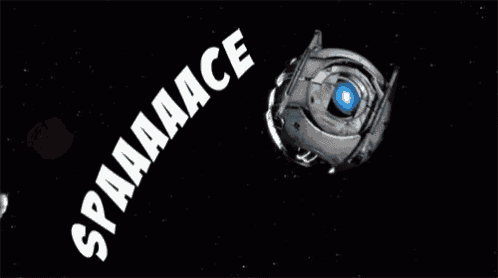

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups

In [ ]:
import icat
icat.initialize()

In [ ]:
dataset = fetch_20newsgroups(subset="train")
df = pd.DataFrame({"text": dataset["data"], "category": [dataset["target_names"][i] for i in dataset["target"]]})
df.category.value_counts()

We've loaded our dataset above, and printed out the number of posts in each category (again, for the problem we're assuming we don't have access to this ground truth, but we'll use it for measuring performance at the end.)

ICAT allows you to build up a binary classifier model, so our goal is to train a model that predicts `1` (<span style="color: #FB8C00">interesting</span>) for all 593 `sci.space` posts, and `0` (<span style="color: #1E88E5">uninteresting</span>) for any texts in any other category.

Some of the following instructions are based on the specific sampled data I was working with when I went through it, so below we reload that specific sample set just for consistency.

In [ ]:
import json
with open("./example_indices.json", 'r') as infile:
    sample_indices = json.load(infile)
icat.initialize()
model = icat.Model(df, text_col="text", default_sample_size=500)
model.data.sample_indices = sample_indices

When we first render the interface below, we have no anchors (no features) and no labeled data, so all of the samples are just in a solid white blob in the very center of the anchorviz ring.

## General Strategy

There are many ways to approach this, but the basic idea I tend to follow is to put "good" anchors with useful keywords on one side of the ring, and "distractor" anchors with anti-keywords on the other side, to essentially visually linearly separate the data. Then, iterate finding words to use by selecting various sets of points and scrolling through looking for potential words (Making frequent use of the "Sample", "Selected", and "All" tabs combined with the search bar) As I look through the texts in clusters, I'll label some as interesting/uninteresting - keep in mind that the model won't start making predictions until at least 10 points have been labeled and there's at least one interesting label and one uninteresting label.

A manual algorithm to follow:

1. Search for some keywords to put in an anchor
2. Lasso select resulting clusters to explore them
3. For texts that shouldn't go in that cluster, find words that are "distractors" - words that indicate it's not in your target group of interest
4. Put those words in dedicated distractor anchors
5. For texts that definitely belong, see what other words could be used to reinforce
6. Lasso select samples in center or think of new words to search in "All" and iterate/go back to 1.

In [ ]:
model.view

<div style="margin-left: 20px; background-color: #1B5E20; color: white; padding: 10px;">
Reminder: in jupyter lab you can right click the cell output above and select "Create new view for cell output" so you can see the instructions/code and the interface at the same time!
</div>

In the beginning there's no clusters at all to work with, so we switch to the All tab, and use the search bar to try and find some space words, like "rocket", "star", and "space"! (Note that as you search, the words you search for get highlighted in white)

In [ ]:
model.data.current_data_tab = "All"
model.data.search_value = "star"
model.data.search_box.v_model = "star"

"Star" gives us 1762 results, which is a lot, and we see in the first one (ID:2) it's triggering on "starting", so this maybe isn't a good word to use.

In [ ]:
model.data.search_value = "rocket"
model.data.search_box.v_model = "rocket"

188 results, maybe not bad, but scanning through some of these, it looks like "rocket" gets used a lot for more weapons-based discussion, so this isn't a great word either.

In [ ]:
model.data.search_value = "space"
model.data.search_box.v_model = "space"

We get 771 results, and the first several all do indeed seem to be space related! Looks like similarly to star, there's some results that are actually "spaced" etc, so this certainly isn't perfect, but this seems fine to use as a starting point anchor. We can directly make a dictionary anchor from the search string by clicking the "+ new" button next to the search bar.

Alternative ways to create a new dictionary anchor: 
1. Click on the ring border when the little red circle cursor turns cyan and then type in the keywords as a comma delimited list in the keywords textbox in the anchors list
2. In the anchors list next to "New:" click the grey <span style="background-color: #777777">&nbsp;DICTIONARY&nbsp;</span> button, and as above type the keywords into the textbox for that anchor down below

In [ ]:
model.data.search_add_new_btn.click()
model.data.search_value = ""
model.data.search_box.v_model = ""

We now see a bunch of points moved out from the center towards the new anchor, meaning they're being influenced by/activating on that feature. Let's rename it and position it on the right, so stuff on the right side is what we're interested in, and stuff on the left will just be distraction/non-space-related things.

(If you're following along manually, rename an anchor by clicking on the textbox with "New anchor" in the anchors list below anchorviz, type the new name and hit enter. Then click and drag on the anchor point on the ring above and pull it over to the right side.)

In [ ]:
model.anchor_list.anchors[0].anchor_name = "space words"
model.view.anchorviz.modify_anchor_by_id(model.view.anchorviz.anchors[0]["id"], "theta", .3)

<div style="margin-left: 20px; background-color: #00796B; color: white; padding: 10px;">
Note: points in the center aren't being influenced by any anchors, or in other words this data isn't being represented well by the current feature set to the model. While not always necessary (and sometimes quite difficult), an ideal end state is for all points to be influenced in some capacity by one or more anchors.
</div>

An important technique is to look through various clusters in our little 2D ring space to understand how we could further break them down/better represent the data in them. The best way to do this is to lasso select the cluster, which you do by clicking and dragging within the ring in a circle around the data you want to look at. 

Lasso select the cluster of points next to the space words anchor, and pull up the "selected" tab to view them.

In [ ]:
model.data.selected_indices = [3751, 7499, 2624, 6802, 5429, 5934, 10142, 5006, 7268, 11151, 847, 6817, 11216, 539, 2843, 6108, 2825, 6178, 4443, 8197, 5928, 6437, 10387, 9055, 9496, 6273, 106, 6484, 6987, 6192, 9333, 5969, 1246, 2071, 2844, 3865]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]
model.data.current_data_tab = "Selected"

Looking through some of these, I see a nasa.gov email address (type "nasa" in search to see), those are probably space related things! Let's make a separate "orgs" anchor to capture keywords of organization names, and add nasa to it. We'll place it a little above the space words anchor so we can separate it out as a distinct cluster

In [ ]:
model.add_anchor(icat.DictionaryAnchor(anchor_name="orgs", keywords=["nasa"]))

In [ ]:
model.view.anchorviz.modify_anchor_by_id(model.view.anchorviz.anchors[1]["id"], "theta", -.3)

Let's select just the orgs cluster, the separate set of points only being influenced by "orgs", and look through it

In [ ]:
model.data.selected_indices = [4013, 1100, 5204, 7357, 4330, 773, 1753, 8674, 9210, 6047, 9133]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]

Scrolling to the bottom of the first page, we see a couple that look to be posted on a unix forum, and don't have anything to do with space despite the nasa email address (ID:9210, ID:6047)

<div style="margin-left: 20px; background-color: #00796B; color: white; padding: 10px;">
Note: You can pull up a specific text by id by putting <code>ID:[index to look for]</code> in the search bar
</div>

These don't belong on the right side, so let's make a distractors anchor on the left to pull them away, starting with the keyword "unix".

In [ ]:
model.add_anchor(icat.DictionaryAnchor(anchor_name="distractors", keywords=["unix"]))

In [ ]:
model.view.anchorviz.modify_anchor_by_id(model.view.anchorviz.anchors[2]["id"], "theta", 4.0)

Note that this resulted in a separate cluster on the left now, and several points strewn across the center since they're influenced both by the orgs and the distractors anchor.

<div style="margin-left: 20px; background-color: #00796B; color: white; padding: 10px;">
Note: AnchorViz with dictionary anchors is a visual representation of keyword boolean filters, where matching each individual anchor is an <code>OR</code> condition, and matching across multiple anchors are <code>AND</code>'ed together: Points directly by an anchor all match <code>(anchor1.word1) OR (anchor1.word2)...</code>, while points that show up between multiple anchors match <code>((anchor1.word1) OR (anchor1.word2)...) AND ((anchor2.word1) OR (anchor2.word2)...)</code>
</div>


Continuing to look through the orgs cluster we had selected, the first one (ID:4013) references the moon, that's a good space word! Let's add it to the space words anchor:

In [ ]:
model.anchor_list.anchors[0].keywords = ["space", "moon"]

Another one (ID:1100) mentions the Jet Propulsion Laboratory, which is probably a good space organization to include, but it does appear that this one isn't actually talking about space stuff, so let's add "weapons" and "crime" to distractors

In [ ]:
model.anchor_list.anchors[1].keywords = ["nasa", "jpl", "Jet Propulsion Laboratory"]
model.anchor_list.anchors[2].keywords = ["unix", "weapon", "crime"]

At this point we can also start labelling some of the data we come across. The one just mentioned (ID:1100) definitely isn't related, so let's label it "uninteresting". You can do this by clicking the <span style="background-color: #1976D2">&nbsp;blue "<b>U</b>" button&nbsp;</span> in the Actions column of the row. A blue "<span style="color: #1E88E5">Labeled</span>" text appears below the action buttons to indicate label status (entries you mark as interesting get an orange "<span style="color: #FB8C00">Labeled</span>")

In [ ]:
model.data.apply_label(1100, 0)

Let's lasso the space words cluster again and keep looking through it

In [ ]:
model.data.selected_indices = [7499, 6802, 5429, 5934, 10142, 5006, 11151, 847, 149, 6817, 10519, 539, 2843, 6108, 2825, 6178, 8197, 5928, 6437, 9496, 6273, 106, 6484, 6192, 9333, 1246, 2071, 2844, 3865]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]

The first one (ID:7499) is talking about a bunch of computer science stuff, and the space here is clearly referring to storage space. Let's make a distractor organizations anchor with "western digital", and split out "unix" from the distractors into a new "cs distractors" anchor and include additional keywords "bios" and "hard drive".

In [ ]:
model.add_anchor(icat.DictionaryAnchor(anchor_name="org distractors", keywords=["western digital"]))
model.add_anchor(icat.DictionaryAnchor(anchor_name="cs distractors", keywords=["unix", "hard drive", "bios"]))
model.anchor_list.anchors[2].keywords = ["weapon", "crime"]

In [ ]:
model.view.anchorviz.modify_anchor_by_id(model.view.anchorviz.anchors[3]["id"], "theta", 2.3)
model.view.anchorviz.modify_anchor_by_id(model.view.anchorviz.anchors[4]["id"], "theta", 2.7)

Since ID:7499 is clearly irrelevant, we'll label it as uninteresting as well

In [ ]:
model.data.apply_label(7499, 0)

Let's flip back to the "All" tab and just scroll until we see something interesting

In [ ]:
model.data.current_data_tab = "All"

Nice, ID:4 has "shuttle launch" in the title! "Shuttle" would work! And thinking about it, so would "spacecraft", which has "space" in it but is more specific, so let's add both of those to space words

In [ ]:
model.anchor_list.anchors[0].keywords = ["space", "moon", "shuttle", "spacecraft"]

This might be a good time to let the model start predicting, so let's start labelling interesting points. Start by lasso selecting everything on the right side of the ring

In [ ]:
model.data.selected_indices = [3751, 4013, 5939, 2624, 1100, 6802, 5429, 5934, 10142, 5006, 5204, 7357, 4330, 11151, 847, 149, 773, 6817, 11216, 1753, 10519, 539, 2843, 6108, 3724, 8674, 2825, 6178, 4443, 8197, 5928, 6437, 9055, 9496, 6273, 106, 6484, 6047, 6987, 6192, 9333, 5969, 9133, 1246, 9567, 2071, 2844, 3865]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]

Switch to "Selected" tab and scroll through, labelling the first few we see that are clearly space relevant as interesting by clicking on the <span style="background-color: #F57C00">&nbsp;orange "<b>I</b>" button&nbsp;</span>.

In [ ]:
model.data.current_data_tab = "Selected"

In [ ]:
model.data.apply_label(5939, 1)
model.data.apply_label(2624, 1)
model.data.apply_label(10519, 1)
model.data.apply_label(4443, 1)

We still need a few more, so lasso select one or more of the distractor clusters and label a few uninteresting.

In [ ]:
model.data.selected_indices = [5409, 10260, 7499, 10802, 10087, 2388, 3209, 9276, 7144, 2579, 1554, 9122, 5225, 5822, 10011, 8050, 7387, 4376, 10433, 7181, 8834, 8489, 7588, 7936, 505, 6777, 6684, 4617, 3943, 483, 9334, 4709, 7291, 6806, 6334, 4681, 409, 2160, 1831, 10470, 4881, 7017, 3685, 1952, 4015, 10870, 5046, 4080, 4463, 8478, 4241, 6409, 8775, 6670, 6071, 4817, 10599, 5997, 10711, 1058, 4253, 10419, 3536, 10475]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]

In [ ]:
model.data.apply_label(5409, 0)
model.data.apply_label(10260, 0)
model.data.apply_label(10802, 0)
model.data.apply_label(3209, 0)

We now have predictions and colors! At this point it's good to take a look at all of the percentages in the anchors table - `Cov` indicates what percent (and count) of the data is being influenced by each anchor, and of those, `% Neg` and `% Pos` gives the prediction classification breakdown for uninteresting/interesting respectively. We would expect that the "space words" anchor has a high positive percentage (which when I run this is indeed a high 92.6% interesting), and all of the distractor anchors should have a much higher uninteresting percentage

We can see a couple of points somewhat in the middle of the ring are predicted interesting, but since they're not strictly to the right these may be incorrect, so lasso select them to investigate.


In [ ]:
model.data.selected_indices = [7268, 6987]
model.view.anchorviz.lassoedPointIDs = [str(index) for index in model.data.selected_indices]

Both of these do appear to be incorrect, so we'll label them as uninteresting and add some associated keywords to distractor anchors

In [ ]:
model.data.apply_label(7268, 0)
model.data.apply_label(6987, 0)
model.anchor_list.anchors[4].keywords = ["unix", "hard drive", "bios", "jpeg", "gif"]

<div style="margin-left: 20px; background-color: #00796B; color: white; padding: 10px;">
Note: Sometimes early on the "center unrepresented blob" will all get predicted as interesting, if no labels to that "cluster" have been provided. This can usually be fixed by lasso selecting the middle and labelling one or two as uninteresting, to send the signal that any entries with all 0 features are uninteresting.
</div>

At this point one could continue to iterate on this process: select some points, label a few, and pull out any words that look useful to help distinguish and put them into appropriate existing (or new) anchors. Many other strategies are possible: the default TF-IDF anchor type can be used by clicking on the green <span style='background-color: #42803f'>&nbsp;Example&nbsp;</span> button next to any entry that is representative of some concept you want to pull out. Further exploration can also be done by going to the Sampling tab and randomly picking a new set of (in this case 500) points from the full dataset.

Further exploration is left to the user, but this notebook will end with a brief look at how this model does:

In [ ]:
model.data.active_data[model.data.active_data._pred >= .5].category.value_counts()

Looking at the "predicted interesting" entries and breaking down the ground truth categories, the majority are correctly in the `sci.space` category (when I ran this, 421, out of a target set of 593)

In [ ]:
tp = model.data.active_data[(model.data.active_data.category == "sci.space") & (model.data.active_data._pred >= .5)]
fn = model.data.active_data[(model.data.active_data.category == "sci.space") & (model.data.active_data._pred < .5)]
fp = model.data.active_data[(model.data.active_data.category != "sci.space") & (model.data.active_data._pred >= .5)]
print("True positive: ", tp.shape[0], " False negative: ", fn.shape[0], " False positive: ", fp.shape[0])

It's definitely not stellar, but this is a solid starting point given that we only gave it 12 labeled points and 5 features, involving a total of only 15 keywords.